### Environment preparation 
 updating the required packages i.e. SageMaker Python SDK, pandas and numpy, and specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance or Studio, training, and hosting.
2. The IAM role ARN used to give training and hosting access to your data. See the documentation for how to create these. Note: if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with the appropriate full IAM role ARN string(s).
3. Download data  

In [92]:
# set free when using AWS sageaker
'''
import sys
!{sys.executable} -m pip install pandas numpy --upgrade
'''

'\nimport sys\n!{sys.executable} -m pip install pandas numpy --upgrade\n'

In [93]:
# set free when using AWS sageaker
''' 
import boto3
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/titanic"
#role = get_execution_role()
role = 'arn:aws:iam::614511894774:user/xuefeng-admin'

'''

' \nimport boto3\nimport sagemaker\nfrom sagemaker import get_execution_role\n\nsess = sagemaker.Session()\nbucket = sess.default_bucket()\nprefix = "sagemaker/titanic"\n#role = get_execution_role()\nrole = \'arn:aws:iam::614511894774:user/xuefeng-admin\'\n\n'

### Pre-processing: Data Understanding
1. Import Libraries 

In [94]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import xgboost as xgb

# Modelling Helpers
from sklearn.preprocessing import  Normalizer , scale, LabelEncoder
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel
from time import time
from sklearn.metrics import f1_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from IPython.display import display

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

2. Setup helper Functions
# currently no need

3. Feature engineering
    - Overwie of Data shape/ features 
    - Check missing values 
    - feature creation

In [96]:
row_2017 = pd.read_csv('./data/2017session.csv')
row_2018 = pd.read_csv('./data/2018session.csv')
row_2019 = pd.read_csv('./data/2019session.csv')
row_2020 = pd.read_csv('./data/2020session.csv')
row_2021 = pd.read_csv('./data/2021session.csv')
row_list = [row_2017, row_2018, row_2019, row_2020, row_2021]
# shpe of all data
print ('Datasets:' , 'Row:' , row_2017.shape)
print(row_2017.shape)
print(row_2018.shape)
print(row_2019.shape)
print(row_2020.shape)
print(row_2021.shape)
#row_2017.head()

Datasets: Row: (306, 64)
(306, 64)
(306, 61)
(306, 105)
(306, 105)
(306, 105)


In [97]:
# select initial features

columns_req = ['HomeTeam','AwayTeam','FTHG','FTAG','FTR']

statistics_2017 = row_2017[columns_req]
statistics_2018 = row_2018[columns_req]
statistics_2019 = row_2019[columns_req]
statistics_2020 = row_2020[columns_req]
statistics_2021 = row_2021[columns_req]

In [98]:
def predictions_0(data):
    """ naive predict the winner is Home-team """
    
    predictions = []
    for _, game in data.iterrows():
        if game['FTR'] == 'H':
            predictions.append(1)
        else:
            predictions.append(0)
    return pd.Series(predictions)

# predict accurace: mean value of predicted 5 sessions 
acc_list = []
for i, session in enumerate(row_list):
    acc = sum(predictions_0(session))/len(session)
    acc_list.append(acc)    
acc_mean = np.mean(acc_list)
print('If predict the winner is Home-team, the accuracy is about  {}'.format(acc_mean))   


If predict the winner is Home-team, the accuracy is about  0.43921568627450985


In [99]:
''' 
In Bundeslig matches in a year:
306 matches 
34 'Spieltag'(week)
9 matches one week (full 18 teams in matching)

This sector create 2 new fratures
 HTGD: Home team goals difference
 ATGD: Away team goals difference
'''
# Calculate the cumulative goal difference per team per week
def get_goals_diff(playing_stat):
    # Create a dictionary, teams name as 'Key', teams(18*34)
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    # for every matches
    for i in range(len(playing_stat)):
        # full time goals for home team
        HTGS = playing_stat.iloc[i]['FTHG']
        # full time goals for away team
        ATGS = playing_stat.iloc[i]['FTAG']

        # add cumulative goal difference to home teams
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS-ATGS)
        # add cumulative goal difference to away teams
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS-HTGS)
    

    # rows as team-names, columns as matchweek
    GoalsDifference = pd.DataFrame(data=teams, index = [i for i in range(1,35)]).T
    GoalsDifference[0] = 0
    # colmulate goal difference by weeks
    for i in range(2,35):
        GoalsDifference[i] = GoalsDifference[i] + GoalsDifference[i-1]    
    return GoalsDifference
    

def get_gss(playing_stat):

    # get statistic of goals difference
    GD = get_goals_diff(playing_stat)

    j = 0
    #  creat new features: clear goals for home team and away team
    HTGD = []
    ATGD = []

    # total 306 matches in whole year
    for i in range(306):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        HTGD.append(GD.loc[ht][j])
        ATGD.append(GD.loc[at][j])

        if ((i + 1)% 9) == 0:
            j = j + 1

    # add new created HTGD ATGD features to dataframe
    playing_stat.loc[:,'HTGD'] = HTGD
    playing_stat.loc[:,'ATGD'] = ATGD

    return playing_stat

statistics_2017 = get_gss(statistics_2017)
statistics_2018 = get_gss(statistics_2018)
statistics_2019 = get_gss(statistics_2019)
statistics_2020 = get_gss(statistics_2020)
statistics_2021 = get_gss(statistics_2021)



In [100]:
'''
This sector create 2 new fratures
 HTP: Home team cumulative points
 ATP: Away team cumulative points
 
'''
# calculate cumulative points for each team{ win: 3p; draw: 1p; lose: 0p}
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

def get_cuml_points(matches):
    matches_points = matches.applymap(get_points)
    for i in range(2,35):
        matches_points[i] = matches_points[i] + matches_points[i-1]

    matches_points.insert(column =0, loc = 0, value = [0*i for i in range(18)])
    return matches_points

def get_matches(playing_stat):
    # Create a dictionary, teams name as 'Key', teams(18*34)
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # sort results from each match to teams
    # H：home team win
    # A：away team win
    # D：draw
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            # home team win, then away team lose
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            # away team win, then home team lose
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            # draw
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')

    return pd.DataFrame(data=teams, index = [i for i in range(1,35)]).T

def get_agg_points(playing_stat):
    matches = get_matches(playing_stat)
    cum_pts = get_cuml_points(matches)
    HTP = []
    ATP = []
    j = 0
    for i in range(306):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 9) == 0:
            j = j + 1
    # cumulative points of home team
    playing_stat.loc[:,'HTP'] = HTP
    # cumulative points of away team
    playing_stat.loc[:,'ATP'] = ATP
    return playing_stat

statistics_2017 = get_agg_points(statistics_2017)
statistics_2018 = get_agg_points(statistics_2018)
statistics_2019 = get_agg_points(statistics_2019)
statistics_2020 = get_agg_points(statistics_2020)
statistics_2021 = get_agg_points(statistics_2021)

In [101]:
# add feature:last N matches

# HM1,HM2,HM3 represents results of last 1/2/3 matches from home team
# AM1,AM2,AM3 represents results of last 1/2/3 matches from away team

def get_form(playing_stat,num):
    form = get_matches(playing_stat)
    form_final = form.copy()
    for i in range(num,35):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1
    return form_final


def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    # M represents unknown，which means no enough results(matches) are played
    h = ['M' for i in range(num * 9)]
    a = ['M' for i in range(num * 9)]

    j = num
    for i in range((num*9),306):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        past = form.loc[ht][j]
        h.append(past[num-1])

        past = form.loc[at][j]
        a.append(past[num-1])

        if ((i + 1)% 9) == 0:
            j = j + 1

    playing_stat['HM' + str(num)] = h
    playing_stat['AM' + str(num)] = a

    return playing_stat


def add_form_df(playing_statistics):
    playing_statistics = add_form(playing_statistics,1)
    playing_statistics = add_form(playing_statistics,2)
    playing_statistics = add_form(playing_statistics,3)
    return playing_statistics

statistics_2017 = add_form_df(statistics_2017)
statistics_2018 = add_form_df(statistics_2018)
statistics_2019 = add_form_df(statistics_2019)
statistics_2020 = add_form_df(statistics_2020)
statistics_2021 = add_form_df(statistics_2021)



In [102]:
# add feature: in which week(Spieltag)
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(306):
        MatchWeek.append(j)
        if ((i + 1)% 9) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

statistics_2017 = get_mw(statistics_2017)
statistics_2018 = get_mw(statistics_2018)
statistics_2019 = get_mw(statistics_2019)
statistics_2020 = get_mw(statistics_2020)
statistics_2021 = get_mw(statistics_2021)

In [103]:

#combine data from 'n' years
playing_stat = pd.concat([statistics_2017,
                          statistics_2018,
                          statistics_2019,
                          statistics_2020,
                          statistics_2021
                          ], ignore_index=True)

#get mean value: HTGD, ATGD ,HTP, ATP divided by 'week'
cols = ['HTGD','ATGD','HTP','ATP']
playing_stat.MW = playing_stat.MW.astype(float)
for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW
playing_stat.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGD,ATGD,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,MW
1525,Mainz,Ein Frankfurt,2,2,D,0.147059,-0.117647,1.323529,1.205882,W,D,W,L,L,D,34.0
1526,M'gladbach,Hoffenheim,5,1,H,-0.323529,0.058824,1.235294,1.352941,D,L,W,L,D,D,34.0
1527,Stuttgart,FC Koln,2,1,H,-0.558824,0.117647,0.882353,1.529412,D,L,D,W,L,W,34.0
1528,Union Berlin,Bochum,3,2,H,0.147059,-0.382353,1.588235,1.235294,W,W,D,W,W,L,34.0
1529,Wolfsburg,Bayern Munich,2,2,D,-0.323529,1.764706,1.205882,2.235294,W,D,D,L,W,W,34.0


In [104]:
# drop the intermediate variables and data from first 3 weeks from each session
playing_stat = playing_stat[playing_stat.MW > 3]
playing_stat.drop(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'MW'],1, inplace=True)
playing_stat.tail()

,FTR,HTGD,ATGD,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3
1525,D,0.147059,-0.117647,1.323529,1.205882,W,D,W,L,L,D
1526,H,-0.323529,0.058824,1.235294,1.352941,D,L,W,L,D,D
1527,H,-0.558824,0.117647,0.882353,1.529412,D,L,D,W,L,W
1528,H,0.147059,-0.382353,1.588235,1.235294,W,W,D,W,W,L
1529,D,-0.323529,1.764706,1.205882,2.235294,W,D,D,L,W,W


In [105]:
# print features ready to train the model
playing_stat.keys()

Index(['FTR', 'HTGD', 'ATGD', 'HTP', 'ATP', 'HM1', 'AM1', 'HM2', 'AM2', 'HM3',
       'AM3'],
      dtype='object')

In [106]:
# number of matches
n_matches = playing_stat.shape[0]

# number of features
n_features = playing_stat.shape[1] - 1

# number of wins from home team
n_homewins = len(playing_stat[playing_stat.FTR == 'H'])

# win-rate from home team
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("number of matches: {}".format(n_matches))
print("number of features: {}".format(n_features))
print("number of wins from home team: {}".format(n_homewins))
print("win-rate from home team: {:.2f}%".format(win_rate))

number of matches: 1395
number of features: 10
number of wins from home team: 605
win-rate from home team: 43.37%


In [107]:
# define target: Home team win or not
def only_hw(string):
    if string == 'H':
        return 'H'
    else:
        return 'NH'

playing_stat['FTR'] = playing_stat.FTR.apply(only_hw)

In [108]:
# get labels and feature dataset
X_all = playing_stat.drop(['FTR'],1)
y_all = playing_stat['FTR']

In [109]:
# scaling the dataset
from sklearn.preprocessing import scale

cols = [['HTGD','ATGD','HTP','ATP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [110]:
#tern features into str
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')


def preprocess_features(X):
    '''tern discete features to dummy encoding '''

    output = pd.DataFrame(index = X.index)

    for col, col_data in X.iteritems():

        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)

        output = output.join(col_data)

    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (22 total features):
['HTGD', 'ATGD', 'HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'AM1_D', 'AM1_L', 'AM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'AM2_D', 'AM2_L', 'AM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM3_D', 'AM3_L', 'AM3_W']


In [111]:
# overview of features after pre-processing
print("\nFeature values:")
display(X_all.head())


Feature values:


,HTGD,ATGD,HTP,ATP,HM1_D,HM1_L,HM1_W,AM1_D,AM1_L,AM1_W,...,HM2_W,AM2_D,AM2_L,AM2_W,HM3_D,HM3_L,HM3_W,AM3_D,AM3_L,AM3_W
27,0.624191,0.282129,1.006083,0.462407,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
28,0.624191,-0.023427,0.493510,-1.110727,0,1,0,0,0,1,...,1,0,1,0,0,0,1,0,1,0
29,0.022439,0.587685,-0.531635,-0.586349,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
30,0.925067,-0.023427,0.493510,-0.586349,0,0,1,0,1,0,...,1,1,0,0,0,1,0,0,0,1
31,-0.880189,-0.634539,-1.044208,-0.586349,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

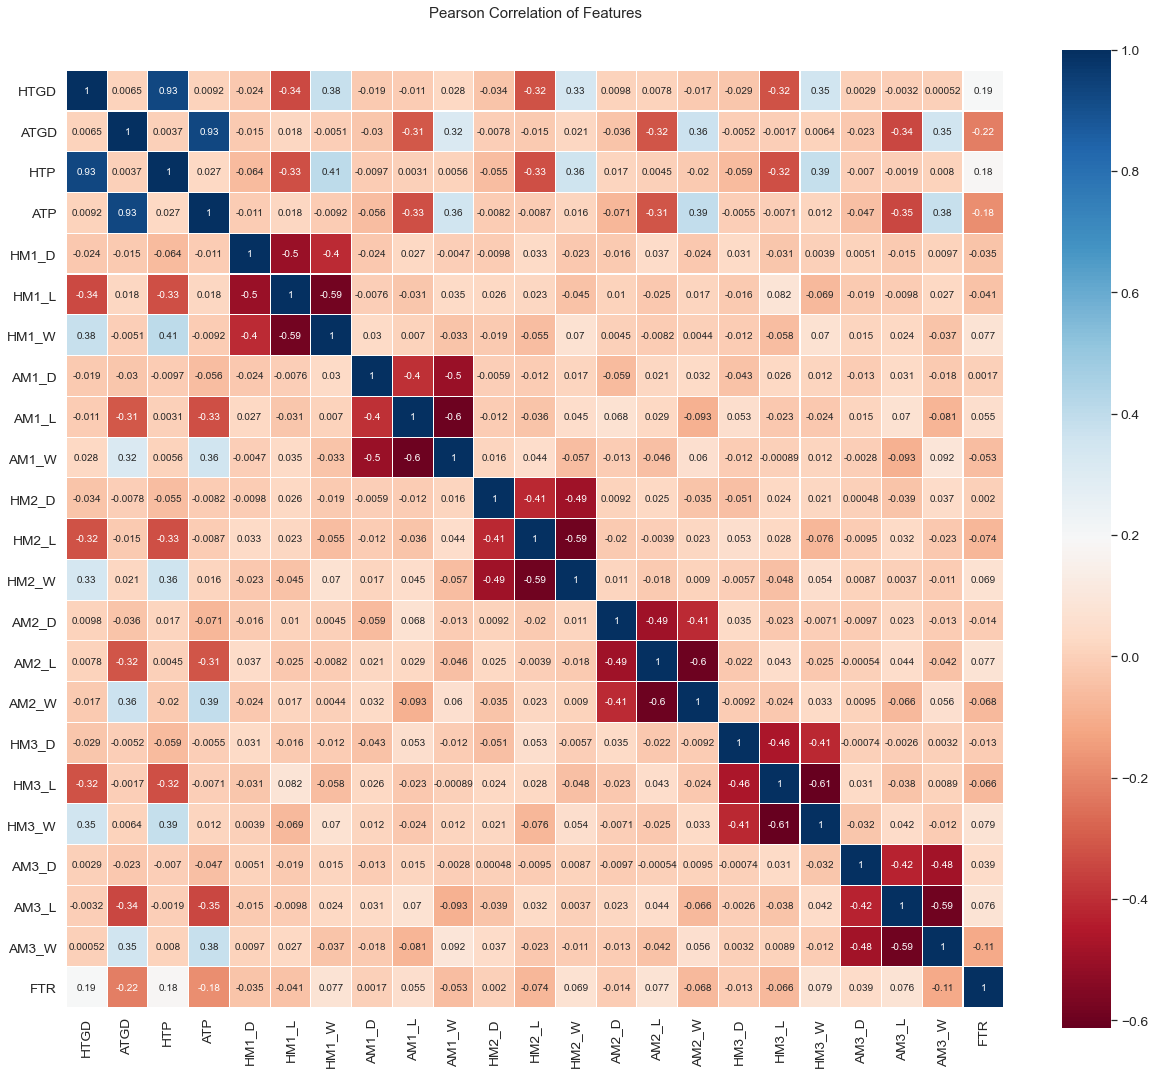

In [112]:
# Pearson heatmap
# mapping target to 0-1
y_all=y_all.map({'NH':0,'H':1})
#combine features
train_data=pd.concat([X_all,y_all],axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(21,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [113]:
# drop 'HTP' and 'ATP' as they highly correlated
X_all=X_all.drop(['HTP','ATP'],axis=1)
train_data=pd.concat([X_all,y_all],axis=1)

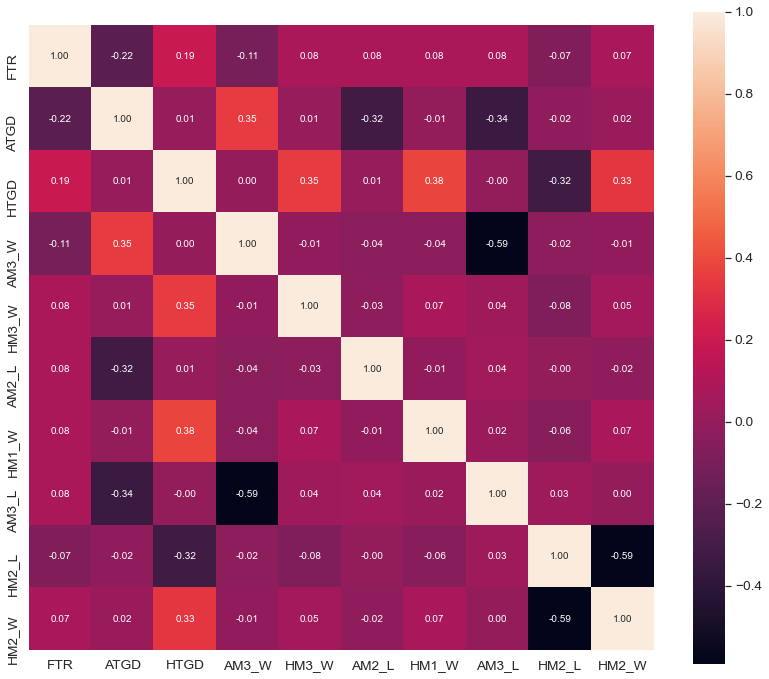

In [114]:
# see rest features

#FTR correlation matrix
plt.figure(figsize=(14,12))
k = 10 #number of variables for heatmap
cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [115]:
# divide datatset into train/test 
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                    test_size =0.3,
                                                    random_state = 2,
                                                    stratify = y_all)

(976, 20)


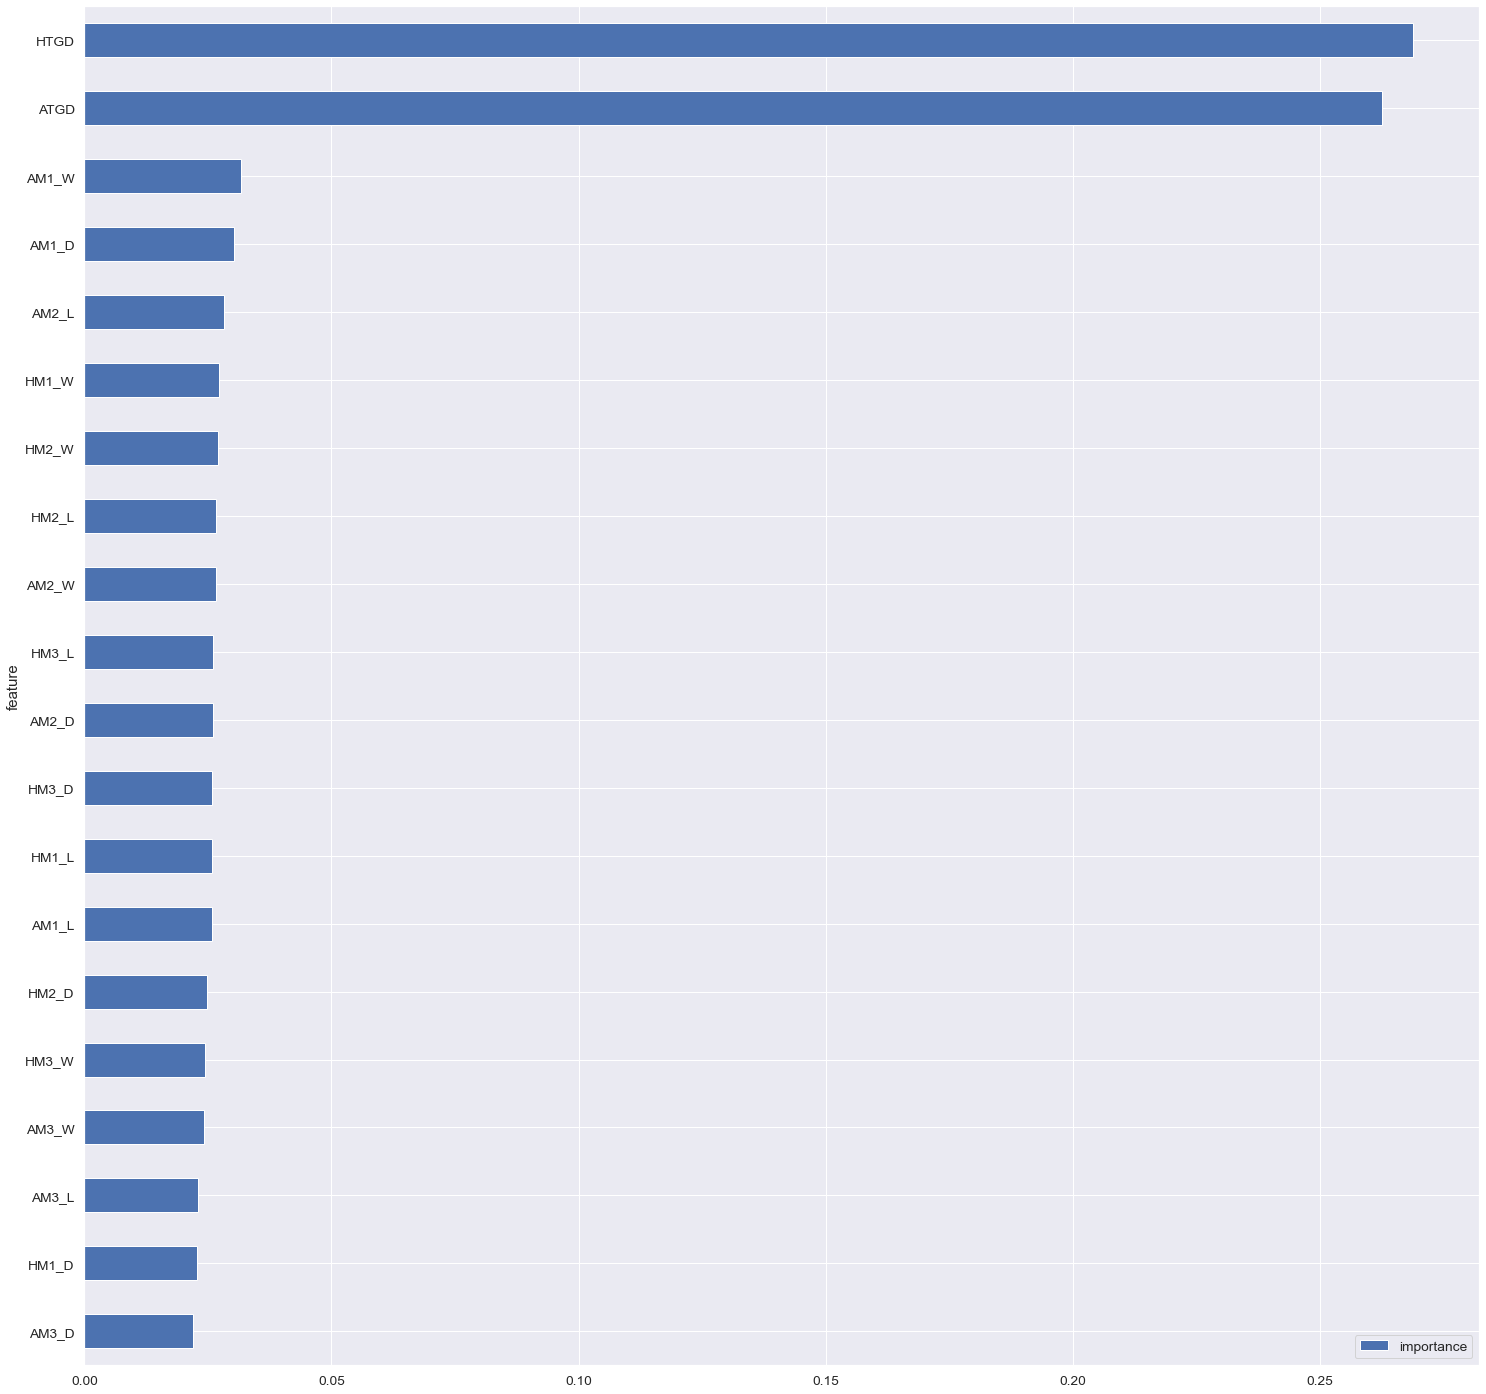

In [116]:
# Before training, see the importance of the features, reducing fearures for the purpose of overfitting-minimize

clf_imp = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf_imp = clf_imp.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf_imp.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))
print(X_train.shape)

In [117]:
def train_classifier(clf, X_train, y_train):
    ''' train model '''

    # record train time
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print("train time {:.4f} sec".format(end - start))

def predict_labels(clf, features, target):
    ''' predict results with trained model '''

    # record predict time
    start = time()
    y_pred = clf.predict(features)
    end = time()

    print("predict time in {:.4f} sec".format(end - start))
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' train and evaluate models:'''

    # train model 
    print('train model of : {}, ，number of samples: {}'.format(clf.__class__.__name__,len(X_train)))
    train_classifier(clf, X_train, y_train)
    
    # evaluate model on train/test dataset
    f1, acc = predict_labels(clf, X_train, y_train)
    print("On train dataset: F1 score and accuracy are {:.4f} , {:.4f}.".format(f1 , acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print("On test dataset: F1 score and accuracy are: {:.4f} , {:.4f}.".format(f1 , acc))
    

In [118]:

#Random Forests Model
model_rf = RandomForestClassifier(n_estimators=100)

#XGBoosting Model
model_XGB = xgb.XGBClassifier(seed = 42)

#Support Vector Machines
model_SVC = SVC(random_state = 42, kernel='rbf',gamma='auto')

#Gradient Boosting Classifier
model_gboost = GradientBoostingClassifier()

#K-nearest neighbors
model_knn = KNeighborsClassifier(n_neighbors = 3)

#Gaussian Naive Bayes
model_gaussianNB = GaussianNB()

#Logistic Regression
model_logreg = LogisticRegression(random_state = 42)

models = [model_rf, model_XGB, model_SVC, model_gboost, model_knn, model_gaussianNB,model_logreg]

for model in models:
    train_predict(clf=model, X_train=X_train, y_train=y_train,  X_test=X_test, y_test=y_test )
    print('****')

train model of : RandomForestClassifier, ，number of samples: 976
train time 0.1603 sec
predict time in 0.0188 sec
On train dataset: F1 score and accuracy are 0.9988 , 0.9990.
predict time in 0.0131 sec
On test dataset: F1 score and accuracy are: 0.5172 , 0.5990.
****
train model of : XGBClassifier, ，number of samples: 976
train time 0.1944 sec
predict time in 0.0039 sec
On train dataset: F1 score and accuracy are 0.9905 , 0.9918.
predict time in 0.0028 sec
On test dataset: F1 score and accuracy are: 0.5255 , 0.5776.
****
train model of : SVC, ，number of samples: 976
train time 0.0544 sec
predict time in 0.1098 sec
On train dataset: F1 score and accuracy are 0.5066 , 0.6527.
predict time in 0.0471 sec
On test dataset: F1 score and accuracy are: 0.4952 , 0.6253.
****
train model of : GradientBoostingClassifier, ，number of samples: 976
train time 0.1277 sec
predict time in 0.0029 sec
On train dataset: F1 score and accuracy are 0.7345 , 0.7807.
predict time in 0.0018 sec
On test dataset: F

In [119]:
# turn run_gs to True to run gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.6280847723704867
Best parameters: {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}
